In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import itertools
from matplotlib import cm
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import mannwhitneyu
from utils.utils import *
from utils.plot_utils import *

# Number of cells in each celltype

In [2]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL_meta.csv',sep='\t')

In [5]:
meta['class'].value_counts()

class
EXC    347811
OLI    181023
INH    151134
AST    129257
OPC     51804
MIC     39214
END     35128
Name: count, dtype: int64

In [6]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/ATAC_FINAL_meta.csv',sep='\t')

In [9]:
meta['Int_Cluster'].value_counts()

Int_Cluster
OLI    148716
EXC    127320
INH     63568
AST     56548
MIC     34775
OPC     26266
END     15840
Name: count, dtype: int64

In [10]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/MULTIOME_FINAL_meta.csv',sep='\t')

In [11]:
meta['class'].value_counts()

class
EXC    51719
INH    23507
OLI    17318
OPC     7974
END     7591
MIC     7436
AST     3886
Name: count, dtype: int64

# Figure 1b: RNA UMAP and Cell Proportions

In [2]:
data = pg.read_input('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr')
data

2024-01-04 17:43:11,142 - pegasusio.readwrite - INFO - zarr file '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr' is loaded.
2024-01-04 17:43:11,144 - pegasusio.readwrite - INFO - Function 'read_input' finished in 302.72s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 935371 x 27982
    Genome: GRCh38; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'n_counts', 'percent_mito', 'doublet', 'doublet_score', 'Channel', 'scale', 'leiden_labels'(cluster), 'hodge_anno', 'lake_anno', 'nenad_anno', 'fine_anno', 'subclass', 'class', 'BrNum', 'Condition', 'Sex', 'Smoking', 'Antidepressant', 'PMI', 'RIN', 'Race', 'AgeDeath', 'subclass2', 'subclass_renamed', 'subclass_final'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'(basis), 'pca_harmony_knn_distances'(knn), 'pca_harmony_knn_indices'(knn)
    varm: 'means', 'partial_sum', 'de_res'
    obsp: 'W_pca_harmony'
    uns: 'genome', 'leiden_resolution', 'modality', 'norm_

In [3]:
ann = sc.AnnData(data.X)
ann.var_names = data.var_names
ann.obs_names = data.obs_names

In [6]:
ann.obs['subtype'] = data.obs['subclass']
ann.obsm['umap'] = data.obsm['X_umap']

In [8]:
colors = [subtype_colors[x] for x in ann.obs.subtype.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


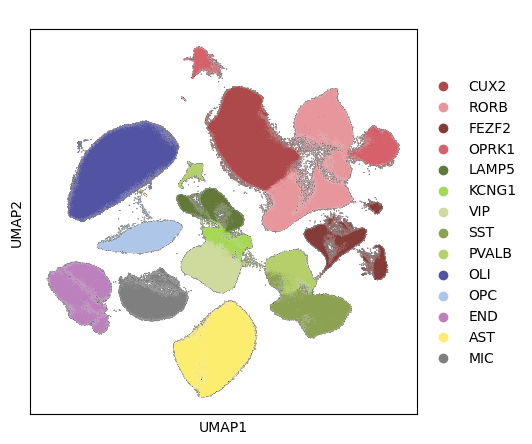

In [9]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='subtype', size=1, add_outline=True,palette=colors,save='_rna_no_labels.pdf',title=' ')

In [76]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL_meta.csv',sep='\t')

In [77]:
arr = np.zeros((3,14))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    x = meta[meta.Condition==cond].subclass.value_counts()/meta[meta.Condition==cond].subclass.value_counts().sum()
    x = x.reindex(subtypes)
    arr[ii] = x.values

In [78]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = subtypes
df = df.reindex(['PTSD','MDD','CON'])

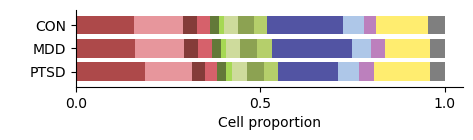

In [79]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()
df.plot(stacked=True,kind='barh',color=[subtype_colors[c] for c in df.columns],figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Figure 1c: ATAC UMAP and Cell Proportions

In [80]:
atac = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/atac_umap.txt',sep='\t')
atac_meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/ATAC_FINAL_meta.csv',sep='\t')
atac['celltype'] = atac_meta['Int_Cluster'].values
atac['celltype'] = atac['celltype'].astype('category')

In [81]:
ann = sc.AnnData(np.empty((atac_meta.shape[0],2)))

In [82]:
ann.obs_names = atac.index

In [83]:
ann.obs['celltype'] = atac['celltype']

In [84]:
ann.obsm['umap'] = np.array(atac[['umap1','umap2']])

In [85]:
colors = [celltype_colors[x] for x in ann.obs.celltype.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


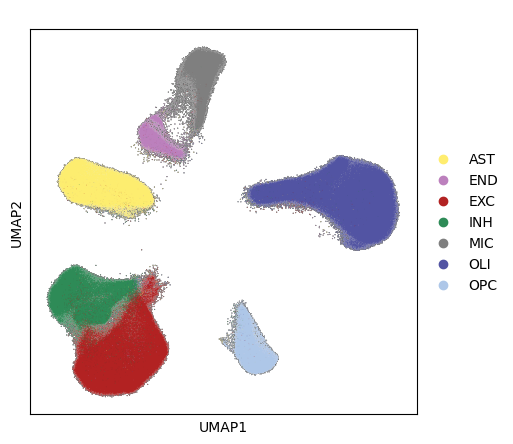

In [33]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='celltype', size=1, add_outline=True,palette=colors,save='_atac_no_labels.pdf',title=' ')

In [86]:
meta = atac_meta
arr = np.zeros((3,7))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    x = meta[meta.Condition==cond]['Int_Cluster'].value_counts()/meta[meta.Condition==cond]['Int_Cluster'].value_counts().sum()
    x = x.reindex(celltypes)
    arr[ii] = x.values

In [87]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = celltypes
df = df.reindex(['PTSD','MDD','CON'])

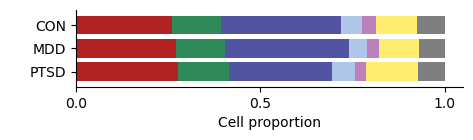

In [88]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()

colors = [celltype_colors[x] for x in df.columns]
df.plot(stacked=True,kind='barh',color=colors,figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Figure 1d: Multiome UMAP and Cell Proportions

In [64]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/MULTIOME_FINAL_meta.csv',sep='\t')
umap = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/multiome_umap.csv',sep=',',index_col=0)
ann = sc.AnnData(np.empty((umap.shape[0],2)))
ann.obs_names = umap.index
ann.obsm['umap'] = np.array(umap[['umap1','umap2']])

In [66]:
ann.obs['subtype'] = meta['subtype'].values
ann.obs['subtype'] = ann.obs['subtype'].astype('category')

In [67]:
colors = [subtype_colors[x] for x in ann.obs.subtype.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


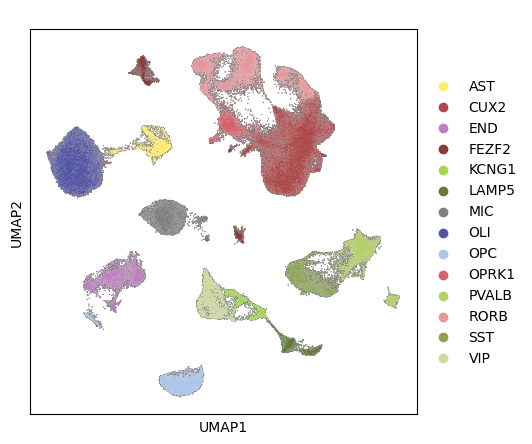

In [69]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='subtype', size=1, add_outline=True, palette=colors,save='_multiome_no_labels.pdf',title=' ')

In [70]:
arr = np.zeros((3,14))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    x = meta[meta.Condition==cond].subtype.value_counts()/meta[meta.Condition==cond].subtype.value_counts().sum()
    x = x.reindex(subtypes)
    arr[ii] = x.values

In [71]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = subtypes

In [72]:
df = df.reindex(['PTSD','MDD','CON'])

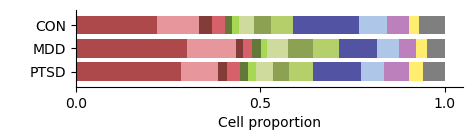

In [75]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()
df.plot(stacked=True,kind='barh',color=[subtype_colors[x] for x in df.columns],figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# RNA Cell Proportions Wilcoxon Test

In [ ]:
brnum = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/PTSD_scRNA_BrNum.csv',sep=',')

In [2]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL_meta.csv',sep='\t')

In [3]:
celltypes = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','OLI','OPC','END','AST','MIC']
data_ptsd = meta[meta.Condition=='PTSD']
n_channels = len(data_ptsd.Channel.unique())
z = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_ptsd.Channel.unique()):
    data_channel = data_ptsd[data_ptsd.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        z[i,j] = data_celltype.shape[0]/data_channel.shape[0]

data_con = meta[meta.Condition=='CON']
n_channels = len(data_con.Channel.unique())
y = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_con.Channel.unique()):
    data_channel = data_con[data_con.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        y[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
data_mdd = meta[meta.Condition=='MDD']
n_channels = len(data_mdd.Channel.unique())
x = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_mdd.Channel.unique()):
    data_channel = data_mdd[data_mdd.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        x[i,j] = data_celltype.shape[0]/data_channel.shape[0]

In [19]:
celltypes = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','OLI','OPC','END','AST','MIC']
data_ptsd = meta[meta.Condition=='PTSD']
n_channels = len(data_ptsd.Channel.unique())
ptsd_prop = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_ptsd.Channel.unique()):
    data_channel = data_ptsd[data_ptsd.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        ptsd_prop[i,j] = data_celltype.shape[0]/data_channel.shape[0]

data_con = meta[meta.Condition=='CON']
n_channels = len(data_con.Channel.unique())
con_prop = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_con.Channel.unique()):
    data_channel = data_con[data_con.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        con_prop[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
data_mdd = meta[meta.Condition=='MDD']
n_channels = len(data_mdd.Channel.unique())
mdd_prop = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_mdd.Channel.unique()):
    data_channel = data_mdd[data_mdd.Channel==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        mdd_prop[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
ptsd_pvals = []
mdd_pvals = []
ptsd_tvals = []
mdd_tvals = []
ptsd_mdd_pvals = []

for j,celltype in enumerate(celltypes):
    w, ptsd_pval = mannwhitneyu(con_prop[:,j],ptsd_prop[:,j])
    w, mdd_pval = mannwhitneyu(con_prop[:,j],mdd_prop[:,j])
    w, ptsd_mdd_pval = mannwhitneyu(ptsd_prop[:,j],mdd_prop[:,j])
    ptsd_pvals.append(ptsd_pval)
    mdd_pvals.append(mdd_pval)
    ptsd_mdd_pvals.append(ptsd_mdd_pval)
    print(celltype,ptsd_pval,mdd_pval,ptsd_mdd_pval)
    
ptsd = pd.DataFrame((z))
con = pd.DataFrame((y))
mdd = pd.DataFrame((x))

CUX2 0.07635374796688671 0.9952967050815603 0.08897083670217437
RORB 0.35652359569492076 0.836544155161046 0.6111920289354047
FEZF2 0.5999332889429412 0.18866890002600778 0.13039005261810305
OPRK1 0.8554308712330383 0.09068594017905189 0.1436437084194009
LAMP5 0.8727948632136077 0.8921540891478279 0.9349722189473807
KCNG1 0.6950640635062042 0.8828411644002137 0.6558785558453599
VIP 0.5846669619913253 0.8642650747372655 0.5018676739471857
SST 0.7279723936857387 0.7547204195640072 0.8066329620703904
PVALB 0.70324031120994 0.20926841250354666 0.5510152221029955
OLI 0.021320324728108665 0.7368707242268051 0.009539955432657957
OPC 0.8037895887379914 0.543745905754568 0.8555749084088116
END 0.23960436720764922 0.4756826830093952 0.816367450606337
AST 0.5922775566647573 0.060050572813406145 0.02941770266045436
MIC 0.4044651059545704 0.7636953195473192 0.4939079766034633


In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']='16'
fig, ax = plt.subplots(figsize=(8,4))

bp1 = ax.boxplot(con,positions=np.arange(1,28,2),vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:gray'),medianprops=dict(color='k'),showcaps=False)
bp2 = ax.boxplot(mdd,positions=np.arange(1,28,2)+0.5,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:orange'),medianprops=dict(color='k'),showcaps=False)
bp3 = ax.boxplot(ptsd,positions=np.arange(1,28,2)+1,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:blue'),medianprops=dict(color='k'),showcaps=False)
plt.xticks(np.arange(1.5,29.5,2),celltypes,rotation=45)
#plt.yticks(np.arange(3),[0,0.2,0.4])
plt.ylabel('Proportion')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],['CON','MDD','PTSD'],frameon=False)
#plt.text(2,0.18,'*')
plt.text(20,0.27,'*')
#plt.text(7.3,0.05,'*')
#plt.text(23.3,0.2,'*')
plt.text(4,0.35,'* 0.01 < p ≤ 0.05')
#plt.savefig('/home/ah2428/figs/rna_proportions.pdf',bbox_inches='tight',dpi=300)

# ATAC Cell Proportions Wilcoxon Test

In [ ]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/ATAC_FINAL_meta.csv',sep='\t')

In [ ]:
celltypes = ['EXC', 'INH', 'OLI', 'OPC', 'END', 'AST', 'MIC']
data_ptsd = meta[meta.Condition=='PTSD']
n_channels = len(data_ptsd.Sample.unique())
print(n_channels)
z = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_ptsd.Sample.unique()):
    data_channel = data_ptsd[data_ptsd.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.Int_Cluster==celltype]
        z[i,j] = data_celltype.shape[0]/data_channel.shape[0]

data_con = meta[meta.Condition=='CON']
n_channels = len(data_con.Sample.unique())
y = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_con.Sample.unique()):
    data_channel = data_con[data_con.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.Int_Cluster==celltype]
        y[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
data_mdd = meta[meta.Condition=='MDD']
n_channels = len(data_mdd.Sample.unique())
x = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_mdd.Sample.unique()):
    data_channel = data_mdd[data_mdd.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.Int_Cluster==celltype]
        x[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
ptsd_pvals = []
mdd_pvals = []
ptsd_tvals = []
mdd_tvals = []
ptsd_mdd_pvals = []

for j,celltype in enumerate(celltypes):
    w, ptsd_pval = mannwhitneyu(z[:,j],y[:,j])
    w, mdd_pval = mannwhitneyu(x[:,j],y[:,j])
    w, ptsd_mdd_pval = mannwhitneyu(z[:,j],x[:,j])
    ptsd_pvals.append(ptsd_pval)
    mdd_pvals.append(mdd_pval)
    ptsd_mdd_pvals.append(ptsd_mdd_pval)
    print(celltype,ptsd_pval,mdd_pval,ptsd_mdd_pval)
    
ptsd = pd.DataFrame((z))
con = pd.DataFrame((y))
mdd = pd.DataFrame((x))

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']='16'
fig, ax = plt.subplots(figsize=(8,4))

bp1 = ax.boxplot(con,positions=np.arange(1,14,2),vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:gray'),medianprops=dict(color='k'),showcaps=False)
bp2 = ax.boxplot(mdd,positions=np.arange(1,14,2)+0.5,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:orange'),medianprops=dict(color='k'),showcaps=False)
bp3 = ax.boxplot(ptsd,positions=np.arange(1,14,2)+1,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:blue'),medianprops=dict(color='k'),showcaps=False)
plt.xticks(np.arange(1.5,15.5,2),celltypes,rotation=45)
#plt.yticks(np.arange(3),[0,0.2,0.4])
plt.ylabel('Proportion')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],['CON','MDD','PTSD'],frameon=False)

plt.text(4,0.35,'* 0.01 < p ≤ 0.05')

# Multiome Cell Proportions Wilcoxon Test

In [ ]:
brnum = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/PTSD_scRNA_BrNum.csv',sep=',')
multiome = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/multiome_covariates.csv',sep=',',header=1)
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/MULTIOME_FINAL_meta.csv',sep='\t')

In [ ]:
celltypes = sorted(meta.subclass.unique())

data_ptsd = meta[meta.Condition=='PTSD']
n_channels = len(data_ptsd.Sample.unique())
print(n_channels)
z = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_ptsd.Sample.unique()):
    data_channel = data_ptsd[data_ptsd.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        z[i,j] = data_celltype.shape[0]/data_channel.shape[0]

data_con = meta[meta.Condition=='CON']
n_channels = len(data_con.Sample.unique())
y = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_con.Sample.unique()):
    data_channel = data_con[data_con.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        y[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
data_mdd = meta[meta.Condition=='MDD']
n_channels = len(data_mdd.Sample.unique())
x = np.zeros((n_channels,len(celltypes)))
for i,channel in enumerate(data_mdd.Sample.unique()):
    data_channel = data_mdd[data_mdd.Sample==channel]
    for j,celltype in enumerate(celltypes):
        data_celltype = data_channel[data_channel.subclass==celltype]
        x[i,j] = data_celltype.shape[0]/data_channel.shape[0]
        
ptsd_pvals = []
mdd_pvals = []
ptsd_tvals = []
mdd_tvals = []
ptsd_mdd_pvals = []

for j,celltype in enumerate(celltypes):
    w, ptsd_pval = mannwhitneyu(z[:,j],y[:,j])
    w, mdd_pval = mannwhitneyu(x[:,j],y[:,j])
    w, ptsd_mdd_pval = mannwhitneyu(z[:,j],x[:,j])
    ptsd_pvals.append(ptsd_pval)
    mdd_pvals.append(mdd_pval)
    print(celltype,ptsd_pval,mdd_pval,ptsd_mdd_pval)
    
ptsd = pd.DataFrame((z))
con = pd.DataFrame((y))
mdd = pd.DataFrame((x))

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']='16'
fig, ax = plt.subplots(figsize=(8,4))

bp1 = ax.boxplot(con,positions=np.arange(1,28,2),vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:gray'),medianprops=dict(color='k'),showcaps=False)
bp2 = ax.boxplot(mdd,positions=np.arange(1,28,2)+0.5,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:orange'),medianprops=dict(color='k'),showcaps=False)
bp3 = ax.boxplot(ptsd,positions=np.arange(1,28,2)+1,vert=True,patch_artist=True,showfliers=False,boxprops=dict(facecolor='tab:blue'),medianprops=dict(color='k'),showcaps=False)
plt.xticks(np.arange(1.5,29.5,2),celltypes,rotation=45)
#plt.yticks(np.arange(3),[0,0.2,0.4])
plt.ylabel('Proportion')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],['CON','MDD','PTSD'],frameon=False)

# Figure 1e: RNA marker genes heatmap

In [89]:
import anndata
from pegasusio import UnimodalData, MultimodalData
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_list_like

from typing import List, Tuple, Union, Optional, Callable
from pegasus.tools import X_from_rep, slicing

import logging
logger = logging.getLogger(__name__)
import seaborn as sns

def heatmap(
    data: Union[MultimodalData, UnimodalData, anndata.AnnData],
    attrs: Union[str, List[str]],
    groupby: str,
    matkey: Optional[str] = None,
    on_average: bool = True,
    switch_axes: bool = False,
    attrs_cluster: Optional[bool] = False,
    attrs_dendrogram: Optional[bool] = True,
    groupby_cluster: Optional[bool] = True,
    groupby_dendrogram: Optional[bool] = True,
    attrs_labelsize: Optional[float] = 10.0,
    groupby_labelsize: Optional[float] = 10.0,
    cbar_labelsize: Optional[float] = 8.0,
    panel_size: Tuple[float, float] = (10, 10),
    return_fig: Optional[bool] = False,
    dpi: Optional[float] = 300.0,
    **kwargs,
) -> Union[plt.Figure, None]:
    """
    Generate a heatmap.

    Parameters
    -----------

    data: ``AnnData`` or ``MultimodalData`` or ``UnimodalData`` object
        Single-cell expression data.
    attrs: ``str`` or ``List[str]``
        Cell attributes or features to plot.
        Cell attributes must exist in ``data.obs`` and must be numeric.
        Features must exist in ``data.var``.
        By default, attrs are plotted as columns.
    groupby: ``str``
        A categorical variable in data.obs that is used to categorize the cells, e.g. Clusters.
        By default, data.obs['groupby'] is plotted as rows.
    matkey: ``str``, optional, default: ``None``
        If matkey is set, select matrix with matkey as keyword in the current modality. Only works for MultimodalData or UnimodalData objects.
    on_average: ``bool``, optional, default: ``True``
        If ``True``, plot cluster average gene expression (i.e. show a Matrixplot); otherwise, plot a general heatmap.
    switch_axes: ``bool``, optional, default: ``False``
        By default, X axis is for attributes, and Y axis for clusters. If this parameter is ``True``, switch the axes.
        Moreover, with ``on_average`` being ``False``, if ``switch_axes`` is ``False``, ``row_cluster`` is enforced to be ``False``; if ``switch_axes`` is ``True``, ``col_cluster`` is enforced to be ``False``.
    attrs_cluster: ``bool``, optional, default: ``False``
        Cluster attributes and generate a attribute-wise dendrogram.
    attrs_dendrogram: ``bool``, optional, default: ``True``
        Only matters if attrs_cluster is True. Show the dendrogram if this option is True.
    groupby_cluster: ``bool``, optional, default: ``True``
        Cluster data.obs['groupby'] and generate a cluster-wise dendrogram.
    groupby_dendrogram: ``bool``, optional, default: ``True``
        Only matters if groupby_cluster is True. Show the dendrogram if this option is True.
    attrs_labelsize: ``float``, optional, default: 10.0
        Fontsize for labels of attrs.
    groupby_labelsize: ``float``, optional, default: 10.0
        Fontsize for labels of data.obs['groupby'].
    cbar_labelsize: ``float``, optional, default: 10.0
        Fontsize of the color bar.
    panel_size: ``Tuple[float, float]``, optional, default: ``(10, 10)``
        Overall size of the heatmap in ``(width, height)`` form.
    return_fig: ``bool``, optional, default: ``False``
        Return a ``Figure`` object if ``True``; return ``None`` otherwise.
    dpi: ``float``, optional, default: ``300.0``
        The resolution in dots per inch.
    kwargs
        Are passed to ``seaborn.heatmap``.

    .. _colormap documentation: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    Returns
    -------

    ``Figure`` object
        A ``matplotlib.figure.Figure`` object containing the dot plot if ``return_fig == True``

    Examples
    --------
    >>> pg.heatmap(data, genes=['CD14', 'TRAC', 'CD34'], groupby='louvain_labels')

    """
    if not isinstance(data, anndata.AnnData):
        cur_matkey = data.current_matrix()
    if matkey is not None:
        assert not isinstance(data, anndata.AnnData)
        data.select_matrix(matkey)

    if isinstance(attrs, str):
        attrs = [attrs]

    obs_keys = []
    genes = []
    for key in attrs:
        if key in data.obs:
            assert is_numeric_dtype(data.obs[key])
            obs_keys.append(key)
        else:
            if key not in data.var_names:
                logger.warning(f"Cannot find gene {key}. Please make sure all genes are included in data.var_names before running this function!")
                return None
            genes.append(key)

    clusters = data.obs[groupby].values
    if not is_categorical_dtype(clusters):
        clusters = pd.Categorical(clusters)
    else:
        clusters = clusters.remove_unused_categories()
    df_list = [pd.DataFrame({'cluster_name': clusters})]

    if len(obs_keys) > 0:
        df_list.append(data.obs[obs_keys].reset_index(drop=True))
    if len(genes) > 0:
        expr_mat = slicing(data[:, genes].X)
        df_list.append(pd.DataFrame(data=expr_mat, columns=genes))
    df = pd.concat(df_list, axis = 1)
    attr_names = df.columns[1:].values
    
    if on_average:
        if not 'cmap' in kwargs.keys():
            kwargs['cmap'] = 'Blues'
        df = df.groupby('cluster_name').mean()
        cluster_ids = df.index
    else:
        cluster_ids = df.pop('cluster_name').values
        if not groupby_cluster:
            idx = cluster_ids.argsort(kind = 'mergesort')
            df = df.iloc[idx, :]  # organize df by category order
            cluster_ids = cluster_ids[idx]

        cell_colors = np.zeros(df.shape[0], dtype=object)
        palette = _get_palette(cluster_ids.categories.size)

        for k, cat in enumerate(cluster_ids.categories):
            cell_colors[cluster_ids == cat] = palette[k]

    
    return df

In [95]:
genes = ['SLC17A7','SATB2','GAD1','GAD2','MOBP','MOG','OLIG1','PDGFRA','FLT1','CLDN5','AQP4','GJA1','APBB1IP','CX3CR1']

df = heatmap(data, attrs=genes, attrs_cluster=False, groupby='subclass', groupby_cluster=False, cmap='Blues', robust=True, switch_axes=True, cbar_kws={'orientation':'horizontal','shrink':0.5,'label':'Avg gene expression','ticks':None})

In [96]:
df

,SLC17A7,SATB2,GAD1,GAD2,MOBP,MOG,OLIG1,PDGFRA,FLT1,CLDN5,AQP4,GJA1,APBB1IP,CX3CR1
cluster_name,,,,,,,,,,,,,,
CUX2,2.689861,3.535886,0.023500,0.016995,0.093933,0.032557,0.011053,0.025739,0.021344,0.007450,0.140797,0.010350,0.017997,0.002014
RORB,3.024233,3.367488,0.046587,0.030955,0.155030,0.046089,0.021845,0.013589,0.027463,0.012991,0.044404,0.017148,0.019563,0.002989
FEZF2,2.679161,3.243293,0.158596,0.099834,0.166118,0.064658,0.047802,0.050862,0.040266,0.016887,0.049844,0.034418,0.021105,0.003670
OPRK1,3.044151,3.731866,0.041103,0.027367,0.151716,0.045536,0.020237,0.019868,0.023517,0.009458,0.064561,0.015034,0.018500,0.002376
LAMP5,0.042638,0.020392,3.427694,4.330656,0.095407,0.062323,0.047283,1.177899,0.045154,0.019171,0.045481,0.033164,0.062375,0.006390
KCNG1,0.120847,0.081676,2.767200,2.839961,0.104030,0.064625,0.067716,0.107242,0.064096,0.021923,0.047555,0.051045,0.043842,0.011891
VIP,0.086440,0.133487,3.147417,1.720918,0.089327,0.067221,0.078464,0.109218,0.376136,0.027420,0.047433,0.049970,0.031065,0.007818
SST,0.134411,0.072514,3.108220,2.434242,0.095503,0.050312,0.036015,0.071625,0.141892,0.004567,0.014494,0.014114,0.021194,0.006491
PVALB,0.071730,0.041389,3.630754,3.113986,0.036560,0.023882,0.035314,0.076138,0.212784,0.010483,0.023717,0.025526,0.131841,0.002425


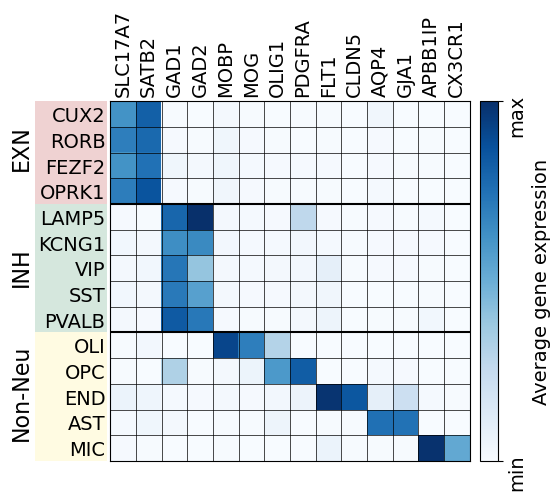

In [98]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size']='14'

fig, ax = plt.subplots(1,1,figsize=(5,5))

minColor = .8
maxColor = 0
blue = truncate_colormap(plt.get_cmap("Blues_r"), minColor, maxColor)
p1 = ax.imshow(np.array(df),cmap='Blues')

x_labels = df.columns
y_labels = df.index
ax.set_xticks(np.arange(len(df.columns)),df.columns,rotation=90)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(df.index)),subtypes)

ax.set_xticks(np.arange(-0.5, len(data.obs['subclass'].unique())-1),minor=True)
ax.set_yticks(np.arange(-0.5, len(genes)-1),minor=True)
ax.grid(which='minor', color='k', linewidth=0.5)
ax.grid(which='major',linewidth=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c = plt.colorbar(p1,cax=cax)
c.ax.set_ylabel('Average gene expression')
c.set_ticks([df.min().min(),df.max().max()])
c.set_ticklabels(['min','max'],rotation=90) 

ax.axhline(y=4-0.5,color='k')
ax.axhline(y=9-0.5,color='k')

for x,num,fc,c,y in zip([0,4,9],[4,5,5],['#b22222','#2E8B57','#ffed6f'],['EXN','INH','Non-Neu'],[2,6.5,12.5]):
    rect = plt.Rectangle((-0.21,-0.5+x), width=0.2, height=num,
                     transform=ax.get_yaxis_transform(), clip_on=False,
                     facecolor=fc,alpha=0.2)
    ax.add_patch(rect)
    ax.text(-4.4, y, c,rotation=90,fontsize=16)
